In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import requests

import pandas as pd
import random
import numpy as np

covid_path = os.path.join('/content','drive','My Drive','covid')


In [77]:
rilevazioni = pd.read_csv('/content/drive/My Drive/IT/Python/covid/rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,15:]

23-03  24-03  25-03  ...  29-03  30-03  31-03
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO           6471   6728   7072  ...   8527   8664   8803
          BRESCIA           5905   6298   6597  ...   8013   8213   8367
          COMO               581    635    706  ...   1014   1061   1101
          CREMONA           2925   3061   3156  ...   3762   3788   3869
          LECCO              934   1015   1076  ...   1381   1437   1470
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA             68     84     99  ...    171    184    186
          REGGIO CALABRIA     94     97    105  ...    189    190    195
          CATANZARO           46     49     51  ...    123    134    139
          VIBO VALENTIA       20     21     23  ...     39     44     44
          CROTONE             62     66     71  ...     90     93     93

[108 rows x 9 columns]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(15, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns), step=1))
  ax.set_xticklabels(list(df.columns))

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

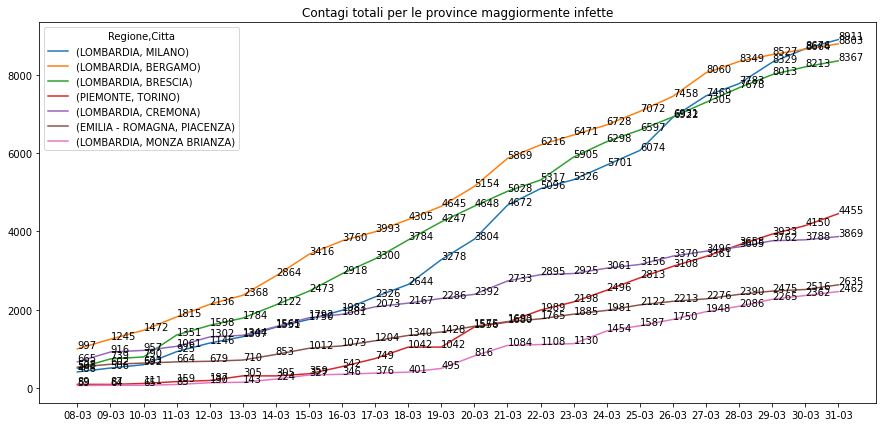

In [80]:
_ = plot_annotate(sorted_by_infections.head(7),'Contagi totali per le province maggiormente infette')

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [83]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  28-03  29-03  30-03  31-03
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    314    546    347    235
          BERGAMO    248    227    343    321  ...    289    178    137    139
          BRESCIA    238     51    561    247  ...    373    335    200    154

[3 rows x 23 columns]

08-03  09-03  10-03  11-03  ...  28-03  29-03  30-03  31-03
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...   7783   8329   8676   8911
          BERGAMO    997   1245   1472   1815  ...   8349   8527   8664   8803
          BRESCIA    501    739    790   1351  ...   7678   8013   8213   8367

[3 rows x 24 columns]

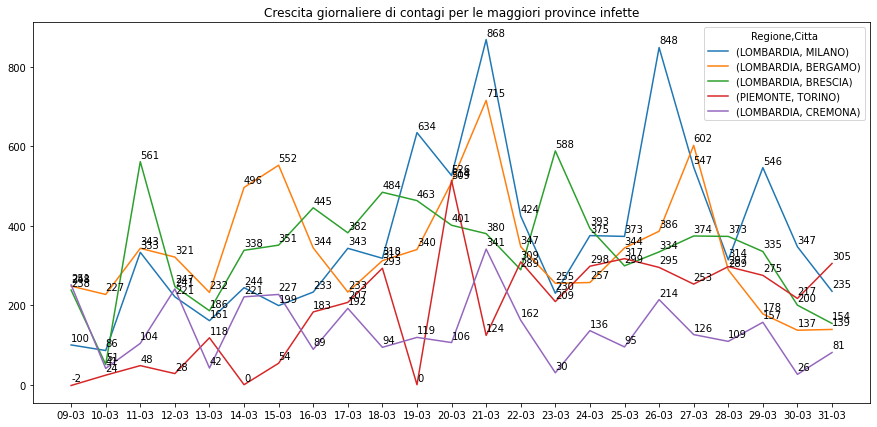

In [84]:
_ = plot_annotate(crescita.head(5), 'Crescita giornaliere di contagi per le maggiori province infette')

In [0]:
#display(crescita.loc[('EMILIA - ROMAGNA','PARMA'),:])
#sortedd_by_infections.loc(('EMILIA - ROMAGNA','PARMA'))

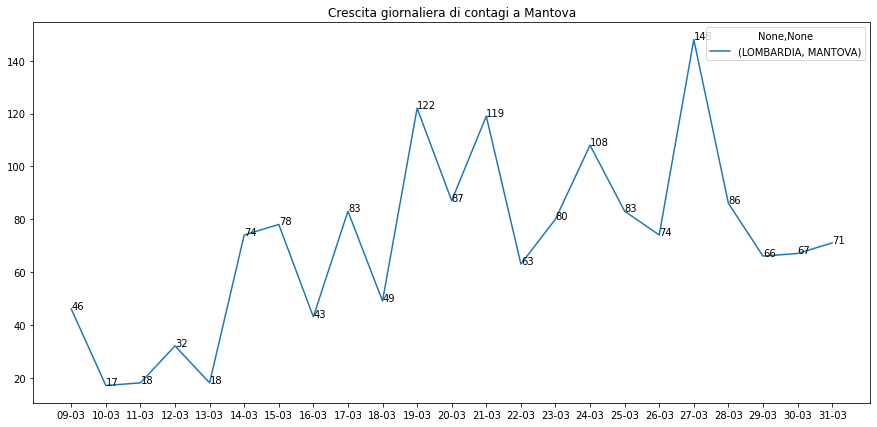

In [86]:
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Crescita giornaliera di contagi a Mantova', ydelta=0)

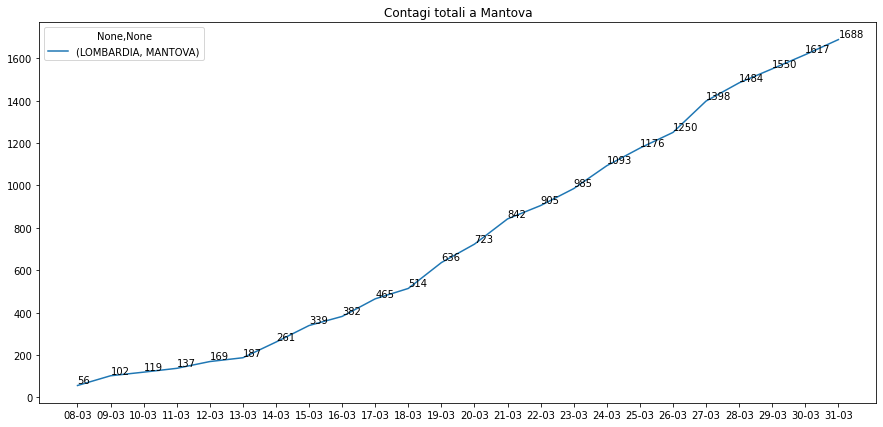

In [87]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Contagi totali a Mantova')

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=sorted_by_infections.index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

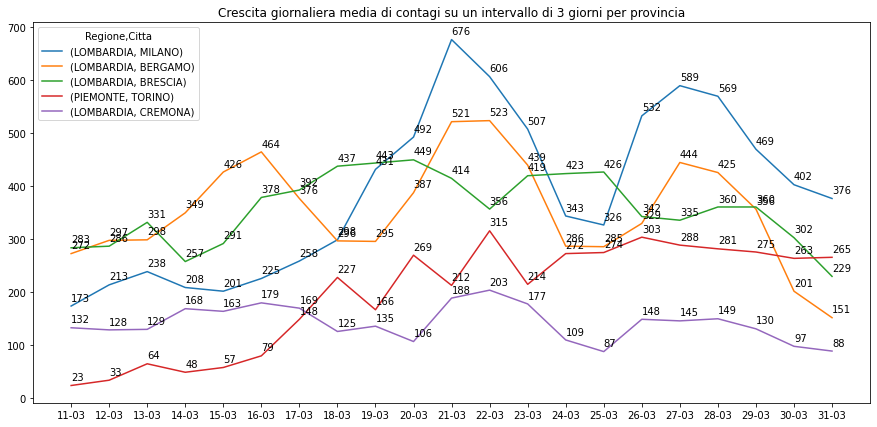

In [90]:
_ = plot_annotate(avg3.head(5), 'Crescita giornaliera media di contagi su un intervallo di 3 giorni per provincia')

In [0]:
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']

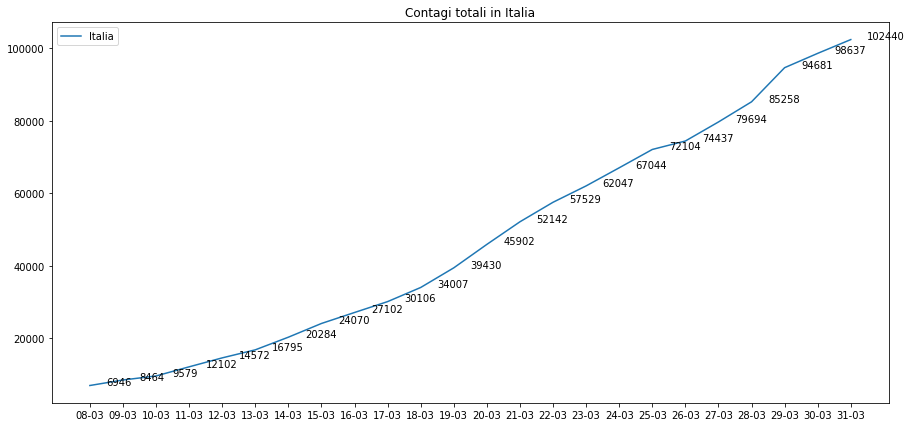

In [92]:
_ = plot_annotate(casi_italia, 'Contagi totali in Italia', xdelta=0.5)

In [0]:
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']

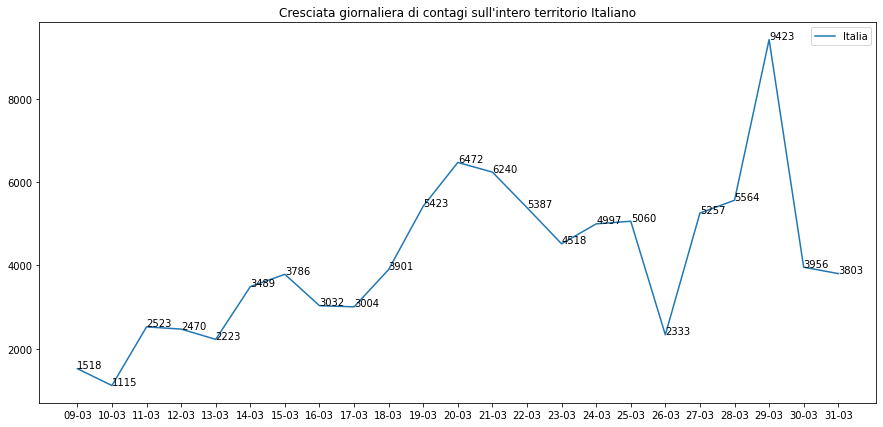

In [94]:
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')